# IMU analysis #2

## Imports

In [13]:
from pydoc import ispath
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import scipy.signal
import math
import statsmodels.api as sm
from ahrs.filters.madgwick import Madgwick
from scipy.spatial.transform import Rotation
from itertools import combinations
from cmath import nan
import json
import argparse
from pathlib import Path
from enum import Enum
from os import path
import re

## Parameters

Set parameters for analysis. Most important is the subject. The Subject can be one of the following: A,B,C,D,E,F,GR,GL(left hand, we didn't use it for our analysis),H,I,J,K.

In [14]:
subject = "A"

id_awinda_base = '01200950'
id_hand_imu = '000_00B4496D'
id_wrist_imu = '000_00B44965'
id_upper_arm_imu = '000_00B448A1'
id_back_imu = '000_00B4489A'

sample_freq = 100 # Hertz
# should results be saved?
save = True
# should madgwick filter be used?
madgwick_filter = True
# filter should always be true, else script does not work
filtered = True

def get_sensor_position_by_id(id):
    if id == id_hand_imu:
        return 'hand'
    elif id == id_wrist_imu:
        return 'wrist'
    elif id == id_upper_arm_imu:
        return 'upper arm'
    elif id == id_back_imu:
        return 'back'

sensors = [id_hand_imu, id_wrist_imu, id_upper_arm_imu, id_back_imu]
if subject == 'test':
    sensors = [id_hand_imu, id_wrist_imu, id_upper_arm_imu]

## Data Organization

Get tasks and corresponding files from overview.xlsx file.

In [15]:

# relax: relax
# static: flex static, ext static, exhaust
# repetition: pro/supi, point, left/right
# other: wrist

type_dict = {'run number': 'int16'}

class TaskType(Enum):
    RELAX = 1
    STATIC = 2
    REPETITION = 3
    OTHER = 4

def get_task_type(task_name):
    return re.sub(r'\s\d+$', '', task_name)
    
def get_signal_type(signal_name):
    return re.sub(r'_\S+$', '', signal_name)

def get_signal_direction(signal_direction):
    return re.sub(r'^\S_', '', signal_direction)

data_folder = '..\\MIRAS_IMU_2022\\data\\' + subject + '\\'



imu_results_file = pd.read_excel(data_folder + "overview.xlsx")
task_list = imu_results_file[~np.isnan(imu_results_file['run number']).values].loc[:,'task name']
task_ids = imu_results_file[~np.isnan(imu_results_file['run number']).values].loc[:,'run number']
print(imu_results_file)

        task name  run number      Time  Test results  Start time  \
0   heading reset         1.0  09:49:00           NaN         NaN   
1   calibration 1         0.0  09:56:00           NaN         NaN   
2   calibration 2         2.0  09:57:00           NaN         NaN   
3      pointing 1         3.0  10:00:00           NaN         4.7   
4      pointing 2         4.0  10:00:00           NaN         2.9   
5      pointing 3         5.0  10:01:00           NaN         2.2   
6      pointing 4         6.0  10:01:00           NaN         1.7   
7    BBT practise         NaN       NaN           NaN         NaN   
8           BBT 1         7.0  10:10:00         81.00         7.5   
9           BBT 2         8.0  10:15:00         89.00         7.5   
10          BBT 3         9.0  10:20:00         89.00        11.0   
11  9HPT practise         NaN       NaN           NaN         NaN   
12         9HPT 1        10.0  10:26:00         15.93        15.0   
13         9HPT 2        11.0  10:

## Reading data_raw

Reading the data_raw from the corresponding task set.

Cut the raw data according to start and end points from the overview.xlsx file. The 9HPT is additionally cut between the change from putting the pegs in to removing them according to the Middle time column of the overview.xlsx file.

In [16]:
"""
    data_raw:
    dict: Task type
        list: repetitions
            dict: sensors
                dict: signal type
                    dict: signal direction
"""

data_raw = {}
data = {}
task_set = []
results = {subject: {}}

for task in task_list: 
    task_type = get_task_type(task)
    task_row = np.where(imu_results_file['task name'] == task)[0][0]
    task_id = int(task_ids[task_list.index[np.where(task_list == task)[0][0]]])
    if task_type == '9HPT':
        task_types = ['9HPT in', '9HPT out']
    else:
        task_types = [task_type]
    results[subject][task] = {}
    for task_type in task_types:
        if not task_type in data_raw.keys():
            data_raw[task_type] = {}
        if not task_type in data.keys():
            data[task_type] = {}
        data_raw[task_type][task] = {}
        data[task_type][task] = {}
        for sensor in sensors:
            data_raw[task_type][task][sensor] = {}
            data[task_type][task][sensor] = {}
            file_name = 'MT_' + id_awinda_base + '-'+ "{:03d}".format(int(task_id)) + '-' + sensor + '.txt'
            curr_data_raw = pd.read_csv(data_folder + "raw_data\\" + file_name, skiprows=4, sep='\t', index_col=0)
            for signal in curr_data_raw.columns:
                signal_type = get_signal_type(signal)
                
                data_raw[task_type][task][sensor][signal_type] = curr_data_raw.filter(regex = '^' + signal_type)
                if np.any(data_raw[task_type][task][sensor][signal_type].index - data_raw[task_type][task][sensor][signal_type].index[0] < 0):
                    data_raw[task_type][task][sensor][signal_type].index = range(0, len(data_raw[task_type][task][sensor][signal_type].index))   
                data_raw[task_type][task][sensor][signal_type].index = (data_raw[task_type][task][sensor][signal_type].index - data_raw[task_type][task][sensor][signal_type].index[0]) / sample_freq
                 
                data[task_type][task][sensor][signal_type] = pd.DataFrame(data_raw[task_type][task][sensor][signal_type], columns=data_raw[task_type][task][sensor][signal_type].columns,
                                                                                index=data_raw[task_type][task][sensor][signal_type].index)
                if math.isnan(imu_results_file.loc[task_row, 'Start time']):
                    start_time = min(data[task_type][task][sensor][signal_type].index)   
                else:
                    start_time = imu_results_file.loc[task_row, 'Start time']
                if math.isnan(imu_results_file.loc[task_row, 'End time']) or imu_results_file.loc[task_row, 'End time'] > max(data[task_type][task][sensor][signal_type].index):
                    end_time = max(data[task_type][task][sensor][signal_type].index)
                else:
                    end_time = imu_results_file.loc[task_row, 'End time']
                
                data[task_type][task][sensor][signal_type] = data[task_type][task][sensor][signal_type].loc[start_time: end_time,:]
                data_raw[task_type][task][sensor][signal_type] = data_raw[task_type][task][sensor][signal_type].loc[start_time: end_time,:]
                if task_type == '9HPT in' or task_type == '9HPT out':
                    if not math.isnan(imu_results_file.loc[task_row, 'Middle time']):
                        middle_time = imu_results_file.loc[task_row, 'Middle time']
                        if task_type == '9HPT in':
                            data[task_type][task][sensor][signal_type]= pd.DataFrame(data[task_type][task][sensor][signal_type].loc[start_time: middle_time,:])
                            data_raw[task_type][task][sensor][signal_type]= pd.DataFrame(data_raw[task_type][task][sensor][signal_type].loc[start_time: middle_time,:])
                        elif task_type == '9HPT out':
                            data[task_type][task][sensor][signal_type]= pd.DataFrame(data[task_type][task][sensor][signal_type].loc[middle_time: end_time,:])
                            data_raw[task_type][task][sensor][signal_type]= pd.DataFrame(data_raw[task_type][task][sensor][signal_type].loc[middle_time: end_time,:])       
#print(data)

## Preprocessing

Same preprocessing steps as in previous analysis. Data is cut, the gravity is removed and a low-pass filter is applied.

### Madgwick Filter

Remove gravity using the madgwick filter like in the previous IMU analysis. Here no conversion between deg/s and rad/s is necessary because the data is already in rad/s.

In [17]:
if madgwick_filter:
    for task_type in data_raw:
            
        for task in data_raw[task_type]:
            
            for sensor in data_raw[task_type][task]:
                data_raw_gyro = pd.DataFrame(np.array(data[task_type][task][sensor]['Gyr']), 
                                             columns = data[task_type][task][sensor]['Gyr'].columns,
                                             index = data[task_type][task][sensor]['Gyr'].index)
                data_raw_accs = pd.DataFrame(np.array(data[task_type][task][sensor]['Acc']), 
                                             columns = data[task_type][task][sensor]['Acc'].columns,
                                             index = data[task_type][task][sensor]['Acc'].index)
                
                curr_data_raw = data_raw_gyro
                gyro = curr_data_raw
                
                # centering gyro data_raw because else error in quaternions
                for col in range(0, len(data_raw_gyro.columns)): 
                    
                    mean = np.median(data_raw_gyro.iloc[:,col])
                    data_raw_gyro.iloc[:,col] = data_raw_gyro.iloc[:,col] - mean 

                # applying madgwick filter
                
                madgwick = Madgwick(gyr=np.array(data_raw_gyro), acc= np.array(data_raw_accs), frequency=sample_freq)
                
                for i in range(0,len(madgwick.Q)):
                    # get current quaternion
                    q = madgwick.Q[i]
                    # get rotation from quaternion
                    rot = Rotation.from_quat([q[1], q[2], q[3], q[0]])
                    
                    # rotate gravity vector
                    gravity_rotated = rot.apply([0,0,9.81], inverse = True)
                    
                    # update current acceleration
                    data_raw_accs.iloc[i,:] = data_raw_accs.iloc[i,:] - gravity_rotated
                    
                
                data[task_type][task][sensor]['Gyr'] = data_raw_gyro
                data[task_type][task][sensor]['Acc'] = data_raw_accs / 9.81

### Low-pass filter

Applying low-pass filter like in previous IMU analysis. Further, high and low frequencies are extracted (before low pass filtering).

In [18]:
# length of each time step

if filtered:
    N = 5
    
    fs = sample_freq
    
    low_freq = 20
    
    low_freq_data = {}
    high_freq_data = {}
    
    for task_type in data:
        
        low_freq_data[task_type] = {}
        high_freq_data[task_type] = {}
        
        for task in data[task_type]:
            
            low_freq_data[task_type][task] = {}
            high_freq_data[task_type][task] = {}
            
            for sensor in data[task_type][task]:
                low_freq_data[task_type][task][sensor] = {}
                high_freq_data[task_type][task][sensor] = {}
                
                # --------------------------------------
                # ACCELERATION
                # --------------------------------------
                acc = data[task_type][task][sensor]['Acc'].loc[:,:]
                #print( data[task_type][task][sensor]['Acc'].index)
                # smoothing data
                [B,A] = scipy.signal.butter(N, low_freq,btype='lowpass', fs=fs)
                data[task_type][task][sensor]['Acc'] = pd.DataFrame(np.array(scipy.signal.filtfilt(B,A,acc,axis=0))
                                                , columns=data[task_type][task][sensor]['Acc'].columns,
                                                index = data[task_type][task][sensor]['Acc'].index)
                #print( data[task_type][task][sensor]['Acc'].index)
                # extracting low frequencies
                [B,A] = scipy.signal.butter(N, 5,btype='lowpass', fs=fs)
                low_freq_data[task_type][task][sensor]['Acc'] = pd.DataFrame(np.array(scipy.signal.filtfilt(B,A,acc,axis=0))
                                                , columns=data[task_type][task][sensor]['Acc'].columns,
                                                index = data[task_type][task][sensor]['Acc'].index)
                # extracting high frequencies
                [B,A] = scipy.signal.butter(N, 5,btype='highpass', fs=fs)
                high_freq_data[task_type][task][sensor]['Acc'] = pd.DataFrame(np.array(scipy.signal.filtfilt(B,A,acc,axis=0))
                                                , columns=data[task_type][task][sensor]['Acc'].columns,
                                                 index = data[task_type][task][sensor]['Acc'].index)
                
                # --------------------------------------
                # ANGULAR VELOCITY
                # --------------------------------------
                
                # gyroscope
                gyr = data[task_type][task][sensor]['Gyr'].loc[:,:]

                # smoothing data
                [B,A] = scipy.signal.butter(N,low_freq,btype='lowpass', fs=fs)
                data[task_type][task][sensor]['Gyr'] = pd.DataFrame(np.array(scipy.signal.filtfilt(B,A,gyr,axis=0)), 
                                                                    columns = gyr.columns,
                                                                    index = gyr.index)

                
                # extracting low frequencies
                [B,A] = scipy.signal.butter(N, 5,btype='lowpass', fs=fs)
                low_freq_data[task_type][task][sensor]['Gyr'] = pd.DataFrame(np.array(scipy.signal.filtfilt(B,A,gyr,axis=0))
                                                , columns=data[task_type][task][sensor]['Gyr'].columns,
                                                index = gyr.index)
                # extracting high frequencies
                [B,A] = scipy.signal.butter(N, 5,btype='highpass', fs=fs)
                high_freq_data[task_type][task][sensor]['Gyr'] = pd.DataFrame(np.array(scipy.signal.filtfilt(B,A,gyr,axis=0))
                                                , columns=data[task_type][task][sensor]['Gyr'].columns,
                                                index = gyr.index)
                # --------------------------------------
                # MAGNETIC FIELD
                # --------------------------------------

                mag = data[task_type][task][sensor]['Mag'].loc[:,:]
                
                # smooting data
                [B,A] = scipy.signal.butter(N,low_freq,btype='lowpass', fs=fs)
                data[task_type][task][sensor]['Mag'] = pd.DataFrame(np.array(scipy.signal.filtfilt(B,A,mag,axis=0)),
                                                                    columns=mag.columns,
                                                                    index = mag.index)


#print(data)

## Feature extraction (Pointing task)

### Signal splitting

Signal is split like in previous analysis.

In [19]:
import re


signal_periods = {}
sensors = {'pointing': [id_hand_imu, id_wrist_imu, id_upper_arm_imu, id_back_imu],
           '9HPT in': [id_hand_imu, id_wrist_imu],
            '9HPT out': [id_hand_imu, id_wrist_imu]}
signal_types = {'pointing': ['Gyr', 'Mag', 'Quat'],
           '9HPT in': ['Gyr', 'Mag', 'Quat'],
           '9HPT out': ['Gyr', 'Mag', 'Quat']}

def find_common_peaks(peaks, task_type):
    """
    Returns the common peaks of the gyroscope and magnetometer signal.
    
    x_gyro: the gyroscope signal of the x-axis
    y_gyro: the gyroscope signal of the y-axis
    z_gyro: the gyroscope signal of the z-axis
    x_mag: the magnetometer signal of the x-axis
    y_mag: the magnetometer signal of the y-axis
    z_mag: the magnetometer signal of the z-axis
    """
    
    # ranges in which signals are clustered together as one splitting point
    # for the first iteration
    close_splitting_points_range = 10 
    # for the other close splitting points found 
    extended_splitting_points_range = 20  
    # minimal needed number of splitting points to define a split
    if task_type == 'pointing':
        min_supporting_points = 16
    elif task_type == '9HPT in':
        min_supporting_points = 6
    elif task_type == '9HPT out':
        min_supporting_points = 6
           
    all_peaks = []
    for peak_list in peaks:
        all_peaks = np.concatenate((all_peaks, peaks[peak_list]))
    peaks = all_peaks
    curr_common_peaks = {'mean': []}
    
    for item in peaks:
        # get all ids of all close splitting points and cluster them together
        ids = np.intersect1d(np.where(peaks < item  + close_splitting_points_range),  np.where(peaks > item - close_splitting_points_range))
        # as long as new splitting points are found within a range they are clustered together
        curr_change = True
        while curr_change:
            old_length = len(ids)
            for id in np.setdiff1d(ids, np.where(peaks == item)):
                curr_item = peaks[id]
                ids = np.union1d(ids, np.intersect1d(np.where(peaks < curr_item  + extended_splitting_points_range),  np.where(peaks > curr_item - extended_splitting_points_range)))
            new_length = len(ids)
            if old_length < new_length:
                curr_change = True
            else:
                curr_change = False
        
        # check if enough splitting points support the split
        if len(ids) >= min_supporting_points:
            # save split and compute mean splitting point
            curr_common_peaks[np.array2string(peaks[ids])] = 1
            curr_mean = np.mean(peaks[ids])
            curr_common_peaks['mean'].append(np.mean(peaks[ids]))
        peaks = np.delete(peaks, ids)
    # sort splitting points
    curr_common_peaks['mean'] = np.sort(curr_common_peaks['mean'])
    return curr_common_peaks    
    
def find_signal_period(data, curr_prominence_gyro, curr_prominence_mag):
    """
    Finds all splitting points for all repetition tasks for given gyroscope and magnetometer data.
    """
    splitting_points = {}

    for task_type in data:
        if task_type == 'pointing':# or task_type == '9HPT in': # for subject H 9HPT in does not work
            splitting_points[task_type] = {}
            factor = sample_freq
            for task in data[task_type]:
                task_row = np.where(imu_results_file['task name'] == task)[0][0]
                peaks = {}
                for sensor in data[task_type][task]:
                    if sensor in sensors[task_type]:
                        for signal_type in data[task_type][task][sensor]:
                            if signal_type in signal_types[task_type]:
                                for direction in data[task_type][task][sensor][signal_type].columns:
                                    max_index = max(data[task_type][task][sensor][signal_type].index)
                                    min_index = min(data[task_type][task][sensor][signal_type].index)
                                    curr_data = data[task_type][task][sensor][signal_type].loc[:,direction]
                                    acorr = sm.tsa.acf(curr_data,nlags=(len(curr_data)-1))
                                    # find peaks of autocorrelation
                                    curr_peaks, curr_properties = scipy.signal.find_peaks(acorr, prominence=(0.3, None))
                                    # refine peaks with more specific parameters
                                    if len(curr_peaks) != 0:
                                        min_width = 0.5 * (curr_properties['right_bases'][np.argmax(curr_properties['prominences'])] - curr_properties['left_bases'][np.argmax(curr_properties['prominences'])])
                                        peaks[str(sensor + ' ' + direction)] = scipy.signal.find_peaks(acorr, distance = min_width, prominence=( curr_prominence_gyro, None))[0]
                                    else:
                                        peaks[str(sensor +' ' +  direction)] = []
                                    """if task_type == '9HPT in':
                                        plt.plot(curr_data)
                                        for peak in peaks[str(sensor + ' ' + direction)]:
                                            x = peak/sample_freq
                                            plt.axvline(x + min(curr_data.index))
                                        plt.show()
                                        plt.close()"""
                # find splitting points    
                curr_common_peaks = find_common_peaks(peaks, task_type)
                    
                if len(curr_common_peaks['mean']) != 0:
                    nrepetitions = int(imu_results_file.loc[task_row, 'Repetitions'])
                    
                    splitting_points[task_type][task] = curr_common_peaks['mean'][:nrepetitions - 1]/sample_freq + min_index
                    curr_common_peaks['mean'] = np.concatenate([[0], curr_common_peaks['mean']])/sample_freq

                    # compute signal periods with splitting points
                    differences = np.diff(curr_common_peaks['mean'])
                    # compute mean signal period and standard deviation
                    mean_signal_period = np.mean(differences)
                    sd_signal_period = np.std(differences)
                    
                    
                    # compute expected signal period using current task type
                    expected_signal_period = max_index/nrepetitions
                    if len(curr_common_peaks['mean']) != nrepetitions:
                        
                        # compute maximal and minimal signal period to identify missing or wrong splitting points
                        maximal_diff = np.max(differences)
                        minimal_diff = np.min(differences)
                        arg_maximal_diff = np.argmax(differences)
                        arg_minimal_diff = np.argmin(differences)
                        
                        # check if there is a signal period that is shorter than expected
                        while (minimal_diff < 0.8 * expected_signal_period) :
                            # compute the low and the high end of this signal period
                            min_point = curr_common_peaks['mean'][arg_minimal_diff]
                            max_point = curr_common_peaks['mean'][arg_minimal_diff + 1]
                            # get the repetition number this signal period is affecting
                            repetition_count = int((min_point - min_point % expected_signal_period) / expected_signal_period)
                            
                            # get the distances to the expected splitting points of the low and the high end of the signal period
                            dist_min_point = np.abs(min_point - repetition_count * expected_signal_period)
                            dist_max_point = np.abs((repetition_count + 1) * expected_signal_period - max_point)
                            
                            # remove the splitting point that is further apart from the expected splitting point
                            if dist_min_point < dist_max_point:
                                arg_delete = arg_minimal_diff + 1
                            else:
                                arg_delete = arg_minimal_diff

                            # update splitting points, mean signal period and minimal signal period
                            curr_common_peaks['mean'] = np.delete( curr_common_peaks['mean'], [arg_delete])
                            curr_common_peaks['mean'] = np.unique(curr_common_peaks['mean'])
                            differences = np.diff(curr_common_peaks['mean'])
                            mean_signal_period = np.mean(differences)
                            minimal_diff = np.min(differences)
                            arg_minimal_diff = np.argmin(differences)
                                                    
                        # update maximal signal period
                        differences = np.diff(curr_common_peaks['mean'])
                        mean_signal_period = np.mean(differences)
                        maximal_diff = np.max(differences)
                        arg_maximal_diff = np.argmax(differences)
                        
                        stop = False
                        # check if there is a signal that is longer than expected
                        while (maximal_diff > 1.2 * expected_signal_period) and not stop:# and arg_maximal_diff != len(differences) - 1: #and arg_maximal_diff != len(differences) - 1:            
                            # get the number of signal periods in between the long signal
                            times = round(maximal_diff/expected_signal_period)
                            if times == 0 or times == 1:
                                stop = True
                                continue 
                            # split the signal into signal periods of the same length
                            new_common_peaks = np.linspace(curr_common_peaks['mean'][arg_maximal_diff], 
                                                        curr_common_peaks['mean'][arg_maximal_diff + 1], 
                                                        (times), endpoint = False)
                            # add those new splitting points and update the mean signal period and maximal distance
                            new_common_peaks = new_common_peaks[1:]
                            curr_common_peaks['mean'] = np.concatenate([new_common_peaks, curr_common_peaks['mean']])  
                            curr_common_peaks['mean'] = np.sort(curr_common_peaks['mean'])
                            curr_common_peaks['mean'] = np.unique(curr_common_peaks['mean'])     
                            differences = np.diff(curr_common_peaks['mean'])
                            mean_signal_period = np.mean(differences)
                            maximal_diff = np.max(differences)
                            arg_maximal_diff = np.argmax(differences)
                            
                        curr_common_peaks['mean'] = np.delete( curr_common_peaks['mean'], [0])  
                        # get the new signal periods and compute the mean and standard deviation of them
                        differences = np.diff(curr_common_peaks['mean'])
                        mean_signal_period = np.mean(differences)
                        sd_signal_period = np.std(differences)
                        
                        # store the signal periods in new array and extend it if it doesn't span the whole signal
                        curr_peak = 0
                        curr_splitting_points = []
                        for peak in curr_common_peaks['mean']:
                            curr_peak = peak 
                            curr_splitting_points.append(peak+ min_index)
                        while(curr_peak < max_index - 1.5 * np.median(differences)):
                            curr_peak += np.median(differences)
                            curr_splitting_points.append(int(curr_peak/factor))
                            
                        differences = np.diff(curr_splitting_points)  
                        if len(curr_splitting_points) - 1 < nrepetitions:
                            if curr_splitting_points[0] < 1.2 * expected_signal_period and curr_splitting_points[0] > 0.7 * expected_signal_period:
                                differences = np.concatenate([[curr_splitting_points[0]], differences])
                        if len(curr_splitting_points) - 1 < nrepetitions:
                            upper_point = max_index
                            last_splitting_point = curr_splitting_points[len(curr_splitting_points)-1]
                            if (upper_point - last_splitting_point) < 1.2 * expected_signal_period and (upper_point - last_splitting_point) > 0.7 * expected_signal_period:
                                differences = np.concatenate([[(upper_point - last_splitting_point)], differences])
                        signal_periods[task] = list(differences)

                        splitting_points[task_type][task] = curr_splitting_points[:nrepetitions - 1]
                    

                    if save:
                        if task_type == 'pointing':
                            signal_period = np.diff(np.concatenate([[min_index], splitting_points[task_type][task], [max_index]]))
                            contains = False
                            if os.path.isfile('Results\\pointing_repetition_period.csv'):
                                with open('Results\\pointing_repetition_period.csv', 'r') as f:
                                    for line in f.readlines():
                                        lines = line.split('\t')
                                        if lines[0] == subject and lines[1] == task:
                                            contains = True 
                            if not contains:
                                with open('Results\\pointing_repetition_period.csv', 'a') as f:    
                                    f.write("%s\t%s\t%s\n"%(subject, task, list(signal_period)))                              
    return splitting_points 


splitting_points = find_signal_period(data, curr_prominence_gyro = 0.2, curr_prominence_mag = 0.1)           

### Splitting

Splits are defined according to the computed splitting points

In [20]:
splitted_data = {}


for task_type in splitting_points:
    # Signal Splitting
    if task_type == 'pointing':
        splitted_data[task_type] = {}
        for task in splitting_points[task_type]:
            splitted_data[task_type][task] = {}

            
            for sensor in data[task_type][task]:
                splitted_data[task_type][task][sensor] = {}
                for signal_type in data[task_type][task][sensor]:
                    split = 0
                    splitted_data[task_type][task][sensor][signal_type] = {}
                    for splitting_point in splitting_points[task_type][task][:4]:
                        if split == 0:
                            last_splitting_point = data[task_type][task][sensor][signal_type].index[0]
                        splitting_point  = round(splitting_point, 2)
                        splitted_data[task_type][task][sensor][signal_type][split] = data[task_type][task][sensor][signal_type].loc[last_splitting_point:splitting_point,:]
                        split += 1
                        last_splitting_point = splitting_point
                        # if last split
                        if split == len(splitting_points[task_type][task]):
                            splitted_data[task_type][task][sensor][signal_type][split] = data[task_type][task][sensor][signal_type].loc[last_splitting_point:,:]
                            
                            
            # Signal alignment
            for sensor in splitted_data[task_type][task]:
                for signal_type in splitted_data[task_type][task][sensor]:
                    for split in splitted_data[task_type][task][sensor][signal_type]:
                        splitted_data[task_type][task][sensor][signal_type][split].index = splitted_data[task_type][task][sensor][signal_type][split].index - splitted_data[task_type][task][sensor][signal_type][split].index[0]

#print(splitted_data)

### Correlation

Compute repetition correlation like in previous analysis. 

In [21]:
correlation = {}
for task_type in splitted_data:
    # Signal Splitting
    if task_type == 'pointing':
        correlation[task_type] = {}
        for task in splitted_data[task_type]:
            correlation[task_type][task] = {}
            for sensor in splitted_data[task_type][task]:
                correlation[task_type][task][sensor] = {}
                for signal_type in splitted_data[task_type][task][sensor]:
                    correlation[task_type][task][sensor][signal_type] = {}
                    # iterate over all combinations of repetitions
                    for split_comb in combinations(splitted_data[task_type][task][sensor][signal_type],2):
                        # compute the correlation and store
                        curr_corr = np.abs(splitted_data[task_type][task][sensor][signal_type][split_comb[0]].corrwith(splitted_data[task_type][task][sensor][signal_type][split_comb[1]], axis = 0, drop = True, method='pearson'))
                        if math.isnan(curr_corr[0]):
                            curr_max_idx = min(len(splitted_data[task_type][task][sensor][signal_type][split_comb[0]]) - 1, len(splitted_data[task_type][task][sensor][signal_type][split_comb[1]]) - 1)
                            for i in range(0, len(splitted_data[task_type][task][sensor][signal_type][split_comb[0]].columns)):
                                curr_corr[i] = np.corrcoef(np.array(splitted_data[task_type][task][sensor][signal_type][split_comb[0]].iloc[:curr_max_idx,i]), 
                                                np.array(splitted_data[task_type][task][sensor][signal_type][split_comb[1]].iloc[:curr_max_idx,i]))[0][1]
                        i = 0
                        for axis in splitted_data[task_type][task][sensor][signal_type][split_comb[0]].columns:  
                            if not axis[len(axis) - 1:] in correlation[task_type][task][sensor][signal_type]:
                                correlation[task_type][task][sensor][signal_type][axis[len(axis) - 1:]] = []
                            correlation[task_type][task][sensor][signal_type][axis[len(axis) - 1:]].append(curr_corr[i])
                            i += 1

                    if save:
                        contains = False
                        if os.path.isfile('Results\\pointing_repetition_correlation.csv'):
                            with open('Results\\pointing_repetition_correlation.csv', 'r') as f:
                                for line in f.readlines():
                                    lines = line.split('\t')
                                    if lines[0] == subject and lines[1] == task and lines[2] == sensor and lines[3] == signal_type:
                                        contains = True 
                        if not contains:
                            with open('Results\\pointing_repetition_correlation.csv', 'a') as f:   
                                count = 0 
                                for axis in data_raw[task_type][task][sensor][signal_type].columns:
                                    f.write("%s\t%s\t%s\t%s\t%s\t%s\n"%(subject, task,sensor,signal_type, re.sub('^\S*_','',axis), correlation[task_type][task][sensor][signal_type][axis[len(axis) - 1:]]))
                                    count += 1


### Maximal Amplitude

Compute maximal amplitude of each repetition like in previous analysis. 

In [22]:
amplitude = {}
for task_type in splitted_data:
    # Signal Splitting
    if task_type == 'pointing':
        amplitude[task_type] = {}
        for task in splitted_data[task_type]:
            amplitude[task_type][task] = {}
            for sensor in splitted_data[task_type][task]:
                amplitude[task_type][task][sensor] = {}
                for signal_type in splitted_data[task_type][task][sensor]:
                    amplitude[task_type][task][sensor][signal_type] = {}
                    # iterate over all combinations of repetitions
                    for axis in data[task_type][task][sensor][signal_type]:
                        amplitudes = []
                        for split in splitted_data[task_type][task][sensor][signal_type]:
                            # compute the amplitude and store
                            amplitudes.append(max(np.abs(splitted_data[task_type][task][sensor][signal_type][split].loc[:,axis])))
                        # compute the mean of all correlations and store them in the results dictionary
                        amplitude[task_type][task][sensor][signal_type][re.sub('^\S*_','',axis)] = amplitudes
                    if save:
                        contains = False
                        if os.path.isfile('Results\\pointing_repetition_amplitude.csv'):
                            with open('Results\\pointing_repetition_amplitude.csv', 'r') as f:
                                for line in f.readlines():
                                    lines = line.split('\t')
                                    if lines[0] == subject and lines[1] == task and lines[2] == sensor and lines[3] == signal_type:
                                        contains = True 
                        if not contains:
                            with open('Results\\pointing_repetition_amplitude.csv', 'a') as f:   
                                for axis in data_raw[task_type][task][sensor][signal_type].columns:
                                    f.write("%s\t%s\t%s\t%s\t%s\t%s\n"%(subject, task,sensor,signal_type, re.sub('^\S*_','',axis), amplitude[task_type][task][sensor][signal_type][re.sub('^\S*_','',axis)]))

### High Frequency Components

Compute standard deviation of high frequency components like in previous analysis. 

In [23]:
for task_type in high_freq_data:
    if task_type == 'pointing':
        for task in high_freq_data[task_type]:
            for sensor in high_freq_data[task_type][task]:
                for signal_type in high_freq_data[task_type][task][sensor]:
                    if save:
                        contains = False
                        if os.path.isfile('Results\\pointing_repetition_high_freq.csv'):
                            with open('Results\\pointing_repetition_high_freq.csv', 'r') as f:
                                for line in f.readlines():
                                    lines = line.split('\t')
                                    if lines[0] == subject and lines[1] == task and lines[2] == sensor and lines[3] == signal_type:
                                        contains = True 
                        if not contains:
                            with open('Results\\pointing_repetition_high_freq.csv', 'a') as f:   
                                for axis in data[task_type][task][sensor][signal_type].columns:
                                    f.write("%s\t%s\t%s\t%s\t%s\t%s\n"%(subject, task,sensor,signal_type, re.sub('^\S*_','',axis), np.std(high_freq_data[task_type][task][sensor][signal_type].loc[:,axis])))
                

## Plot

Plot data with splits.

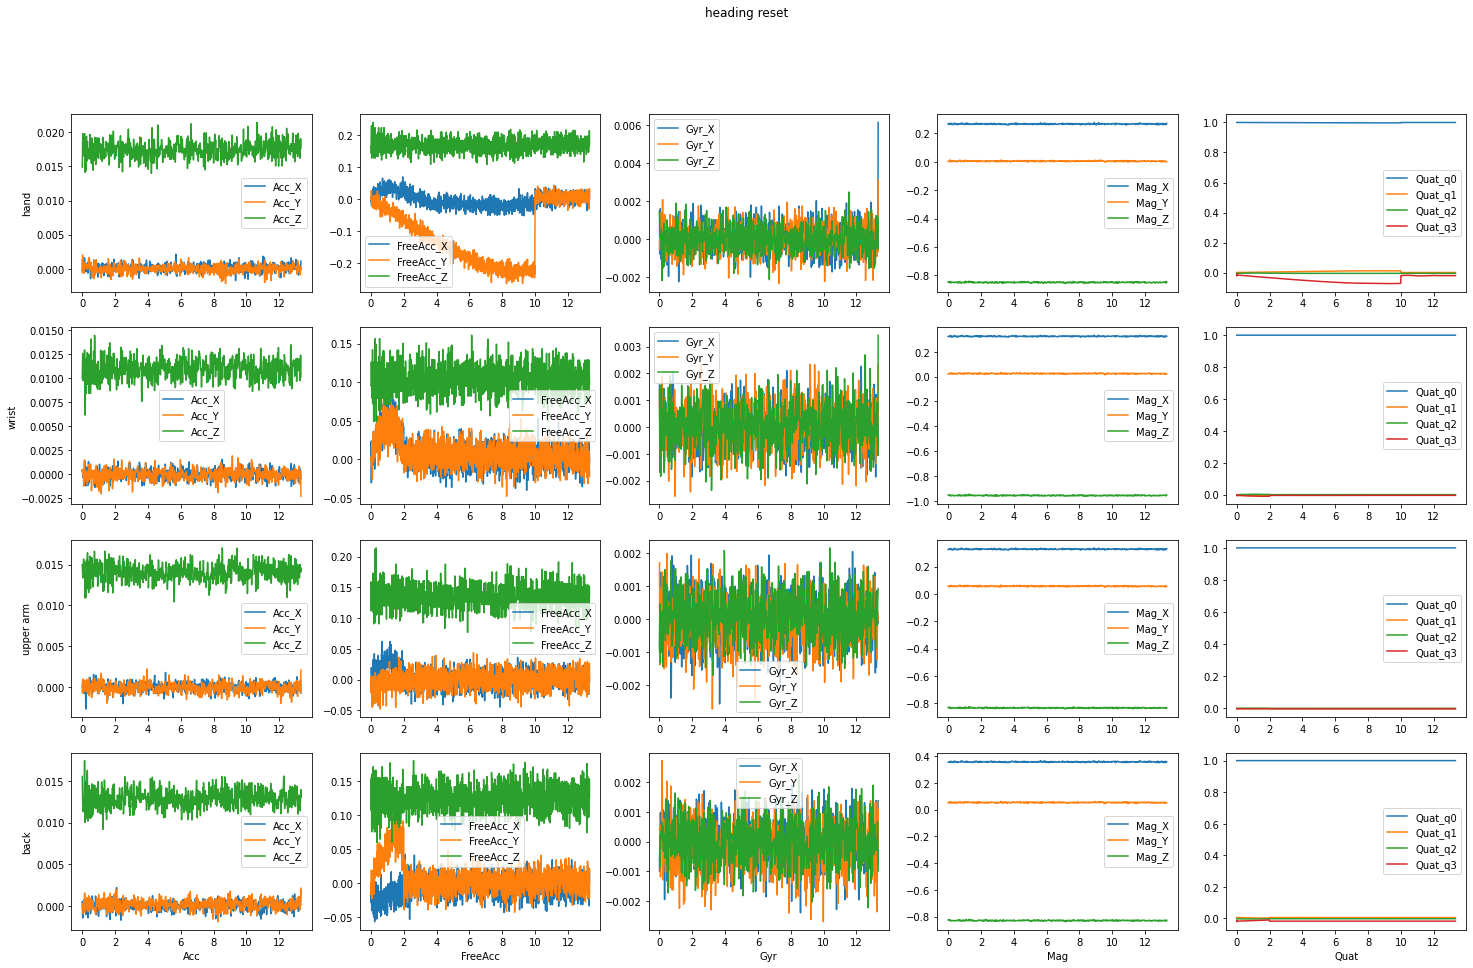

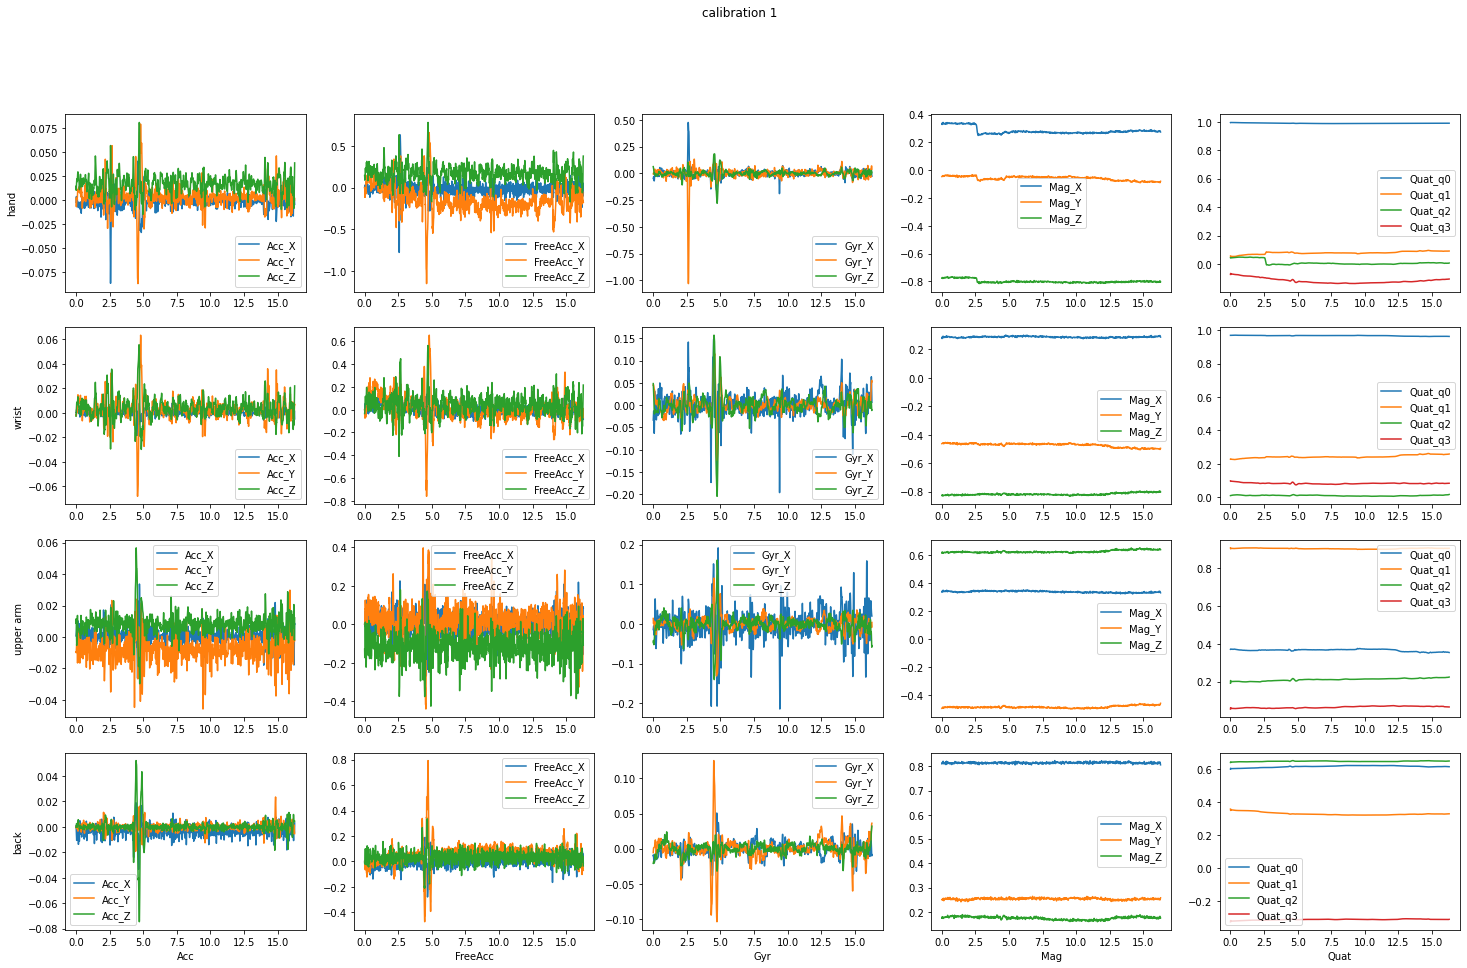

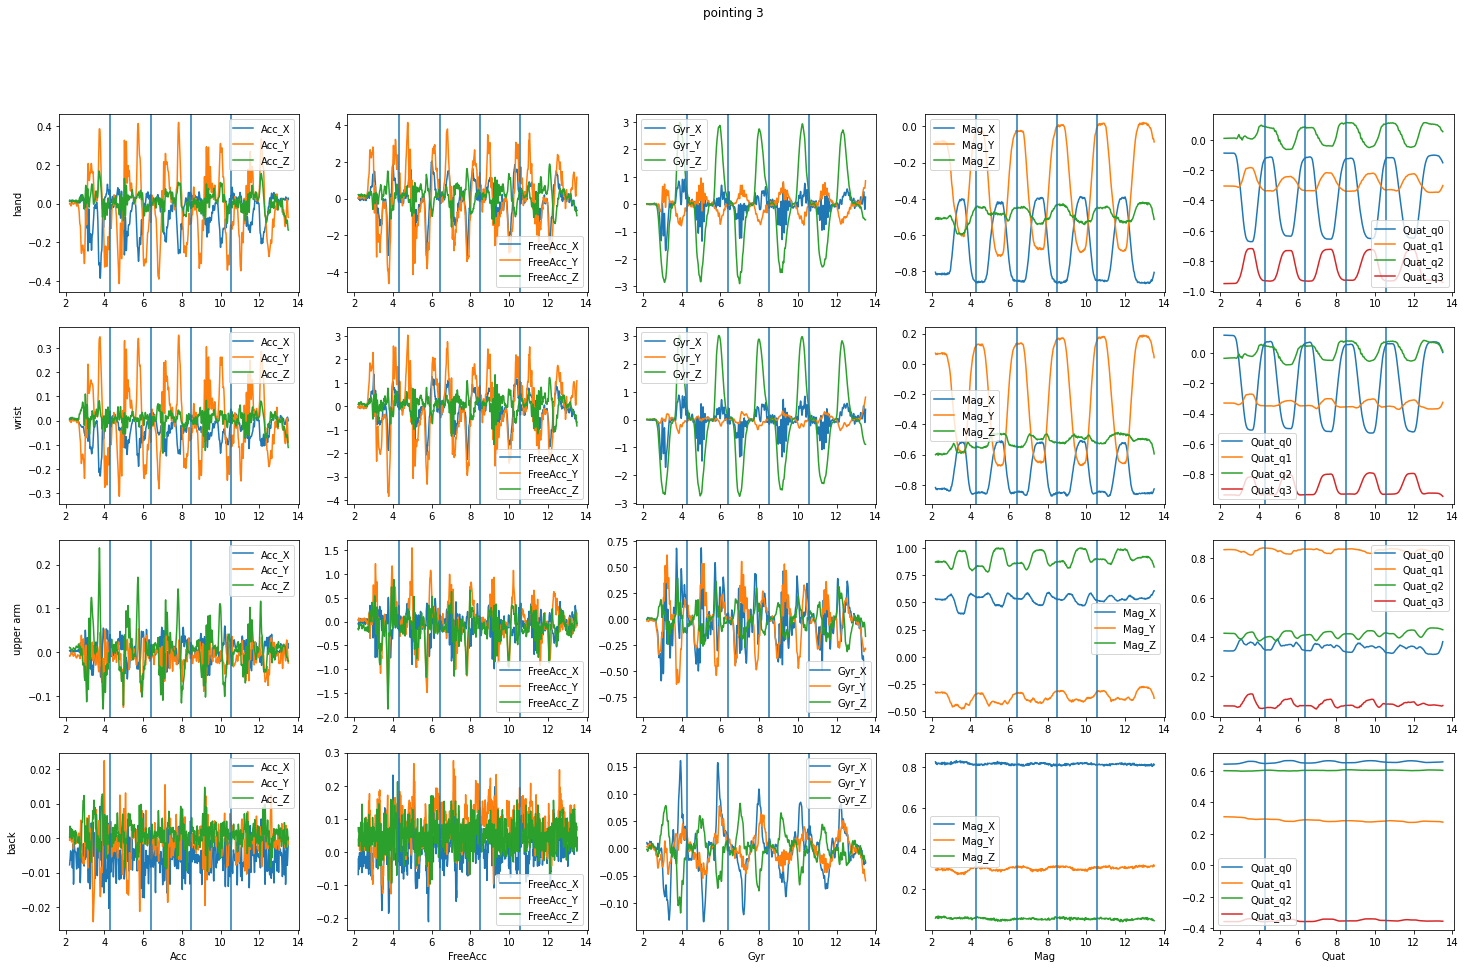

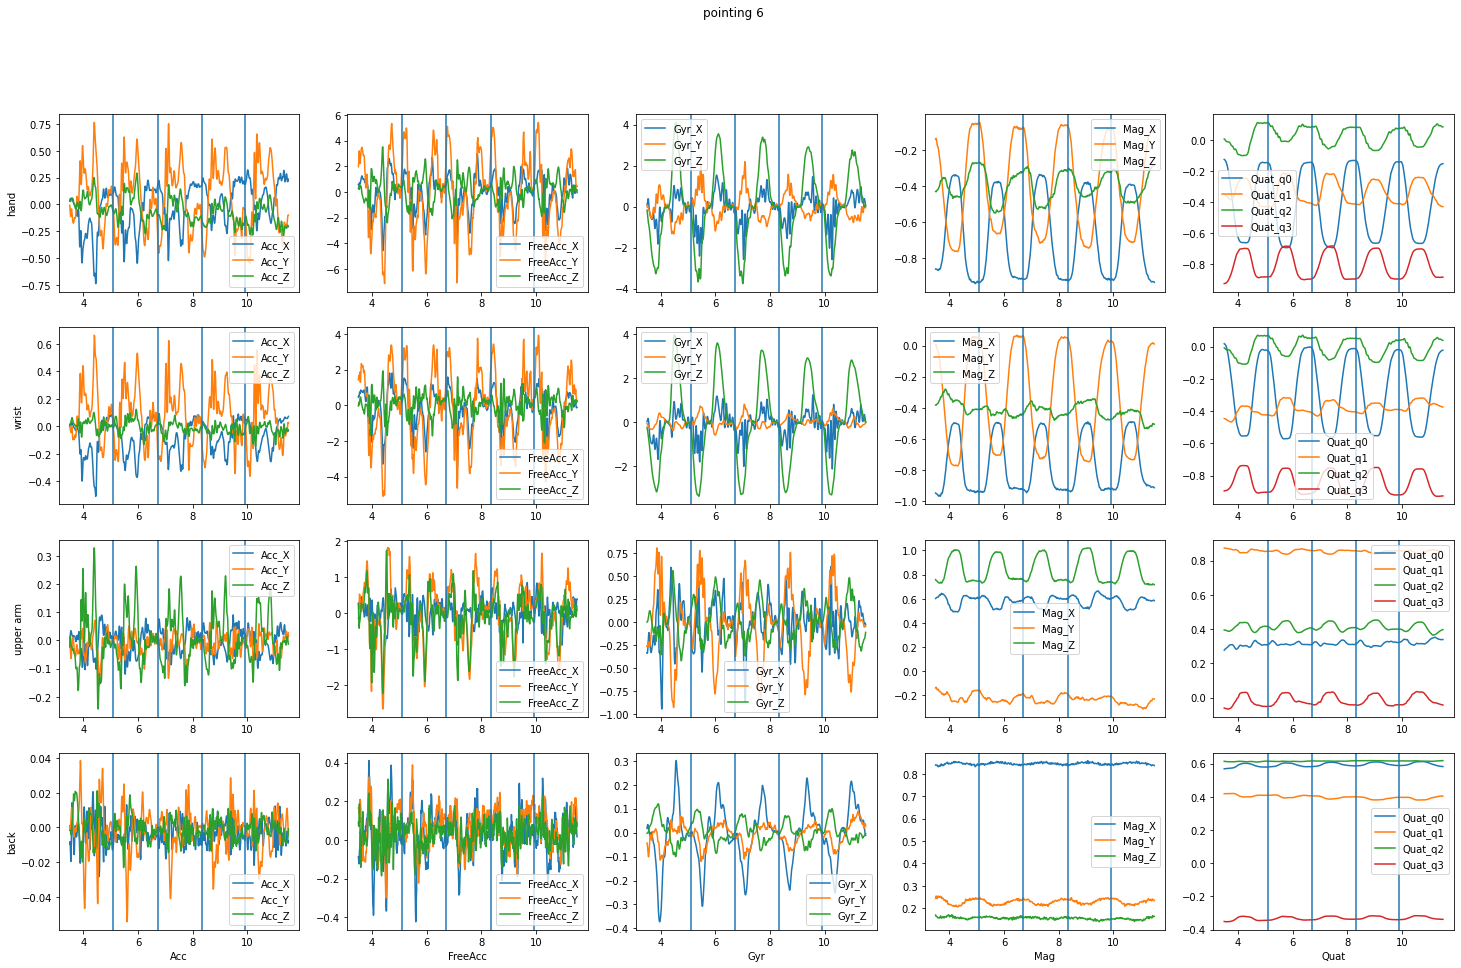

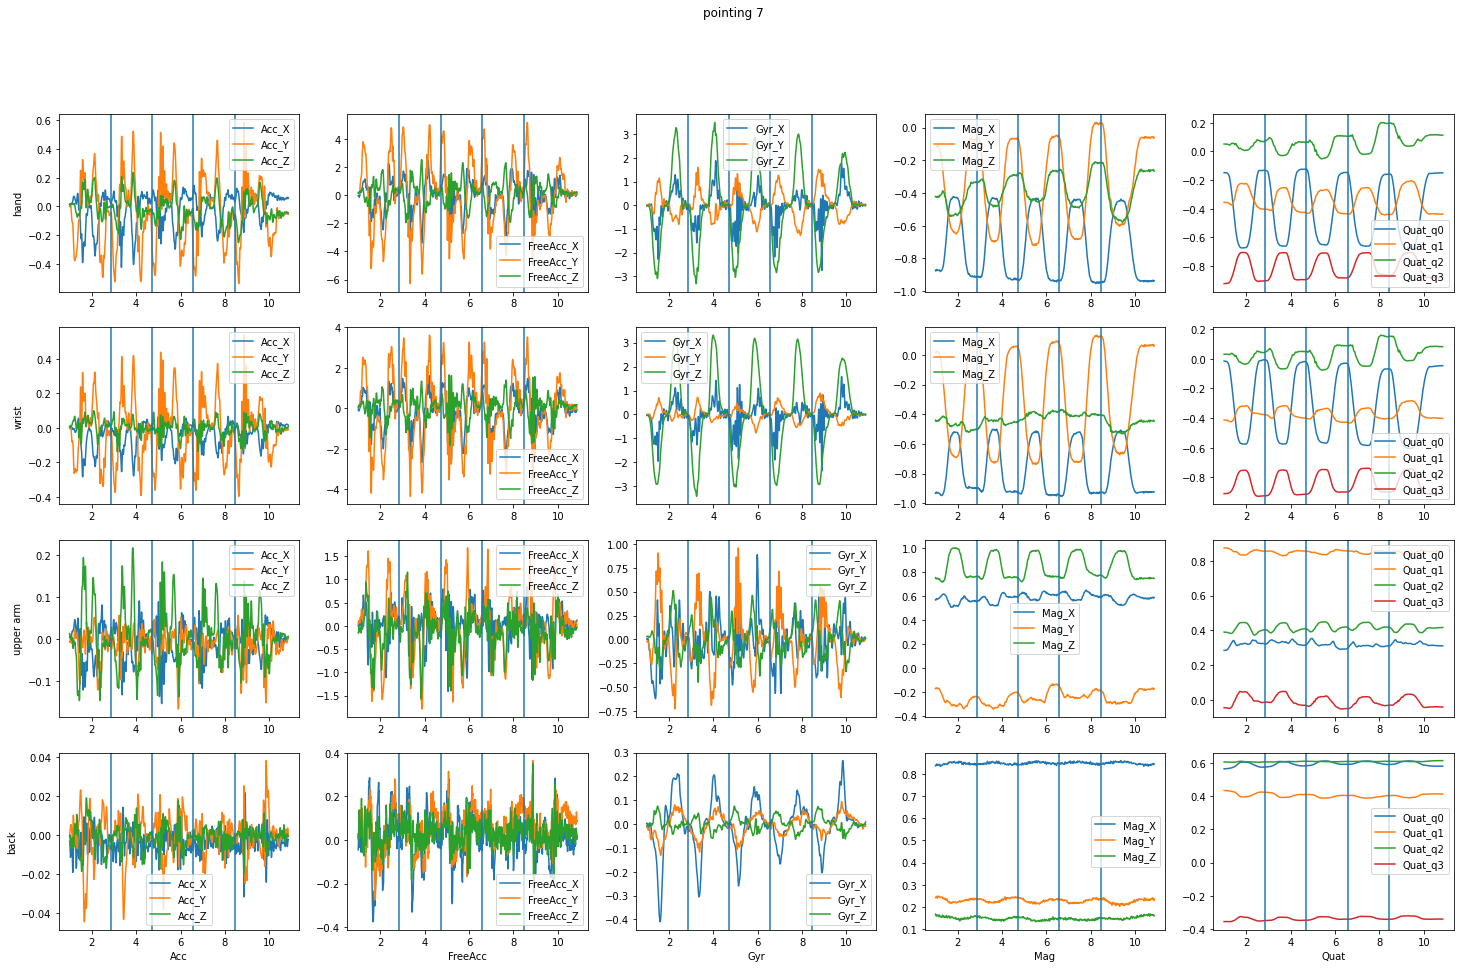

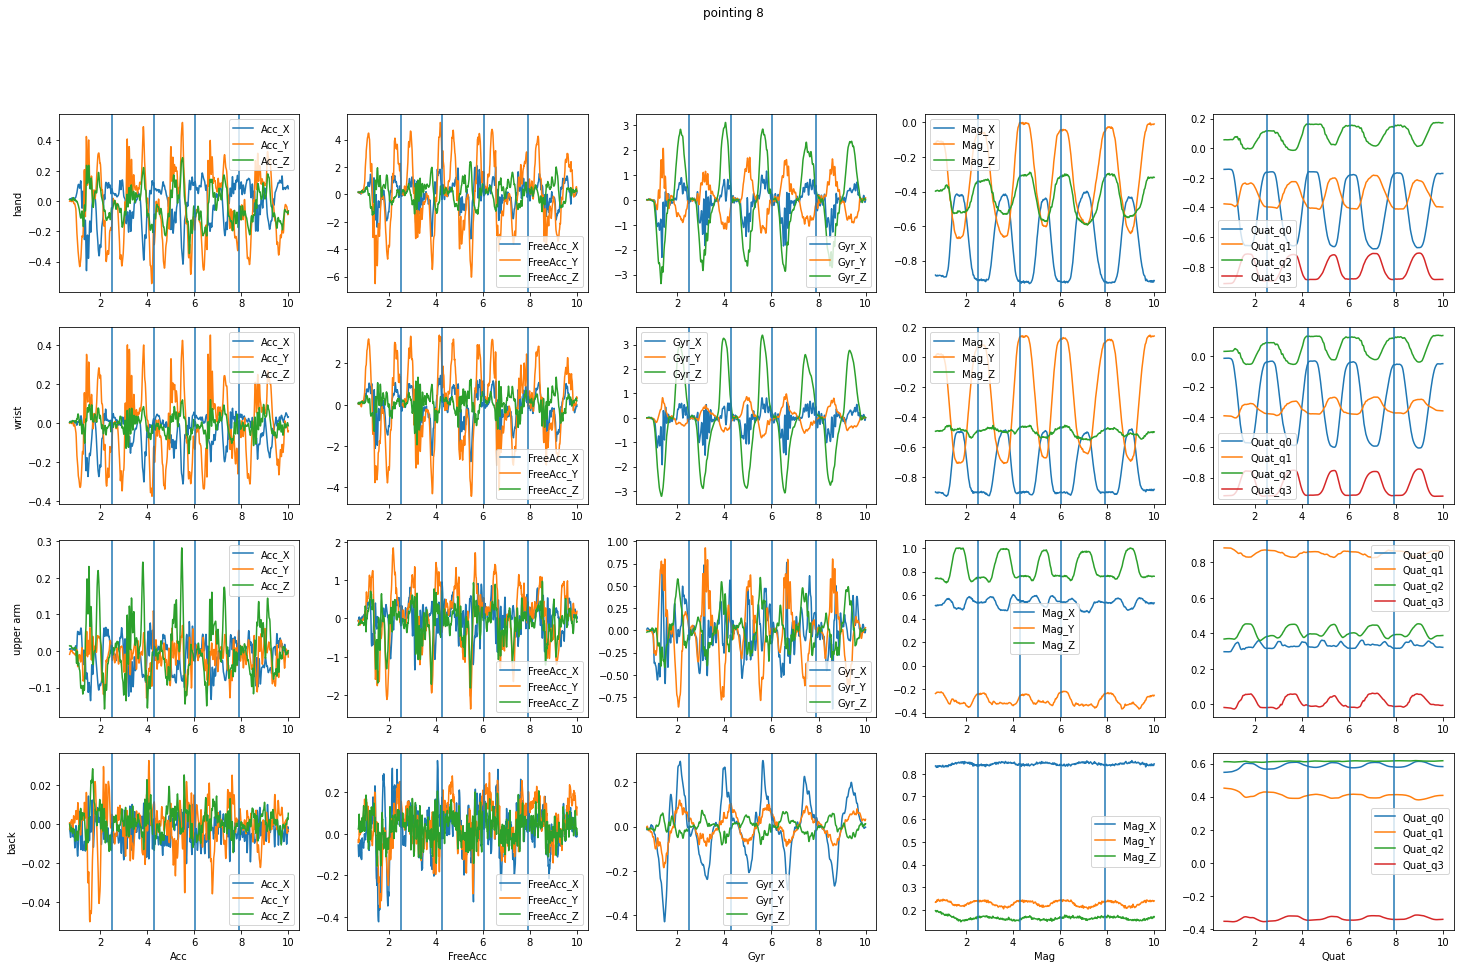

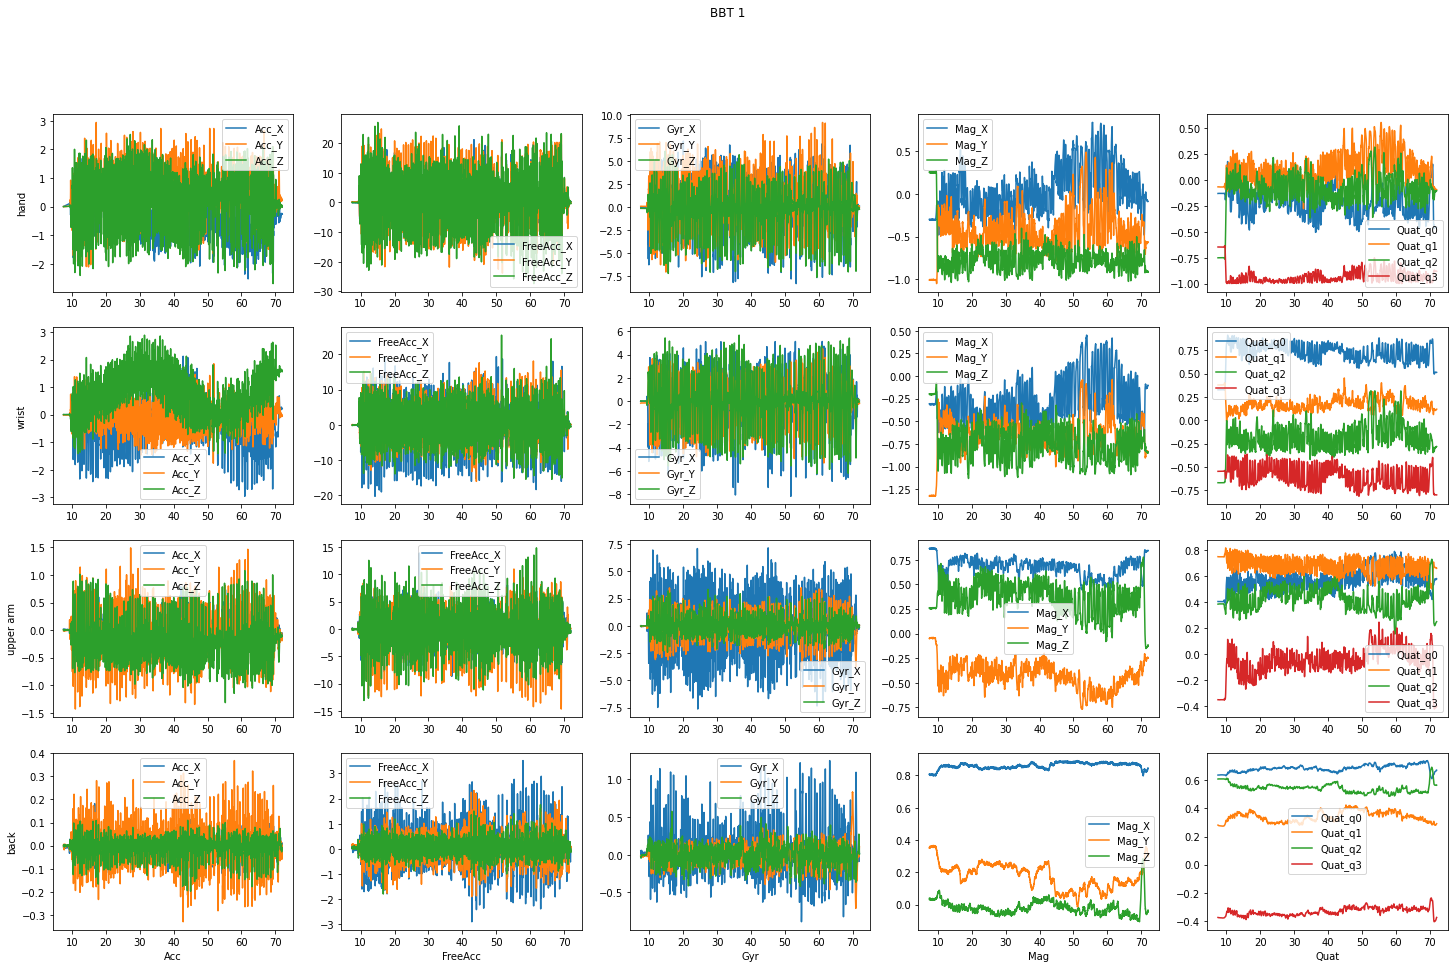

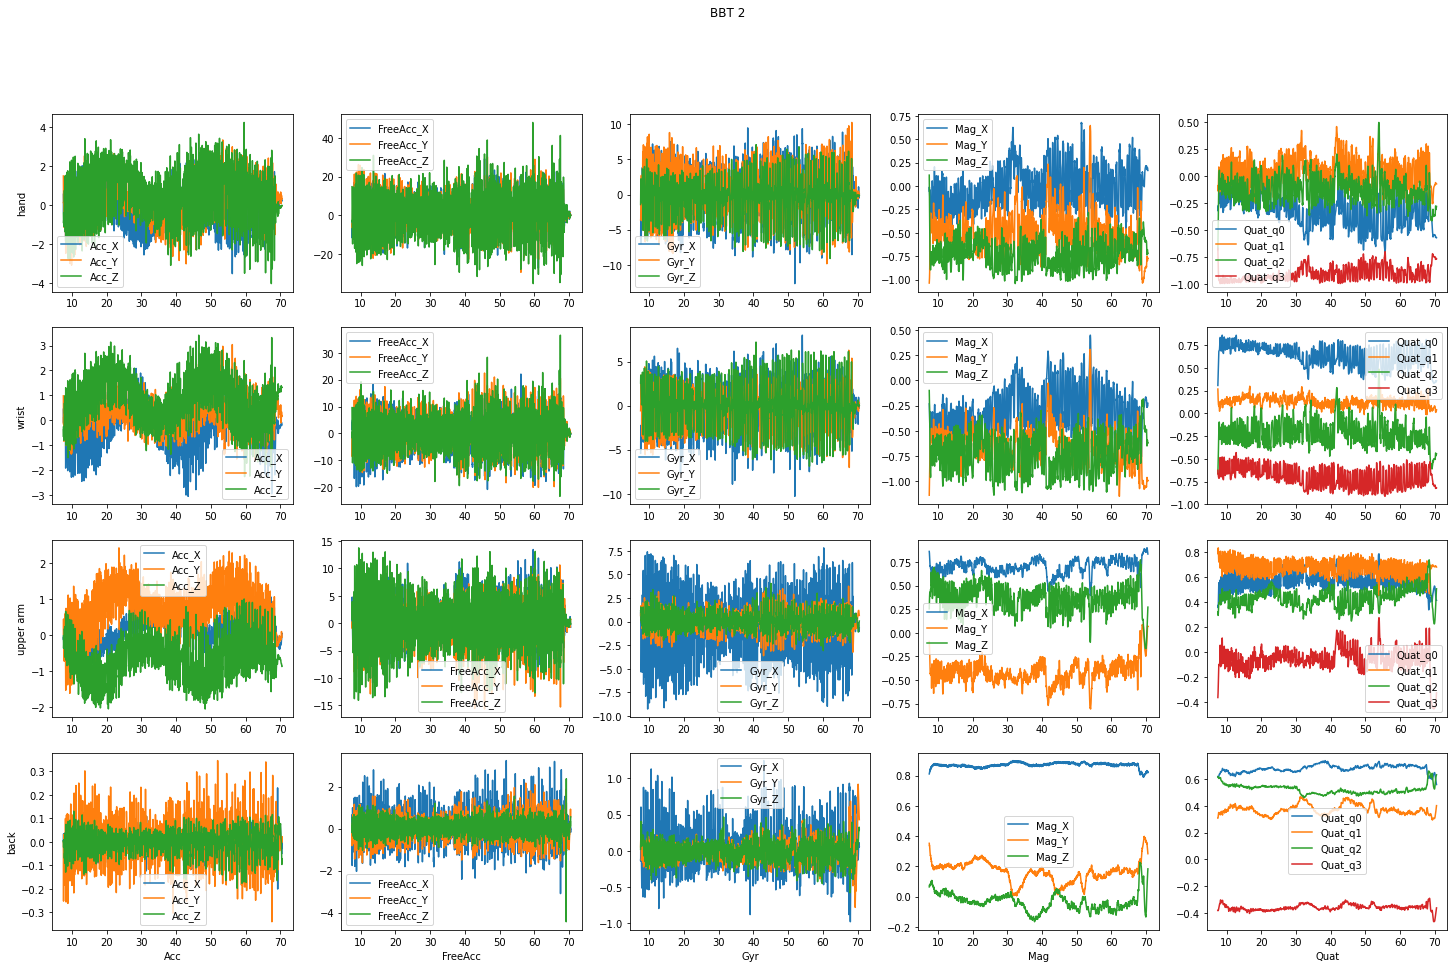

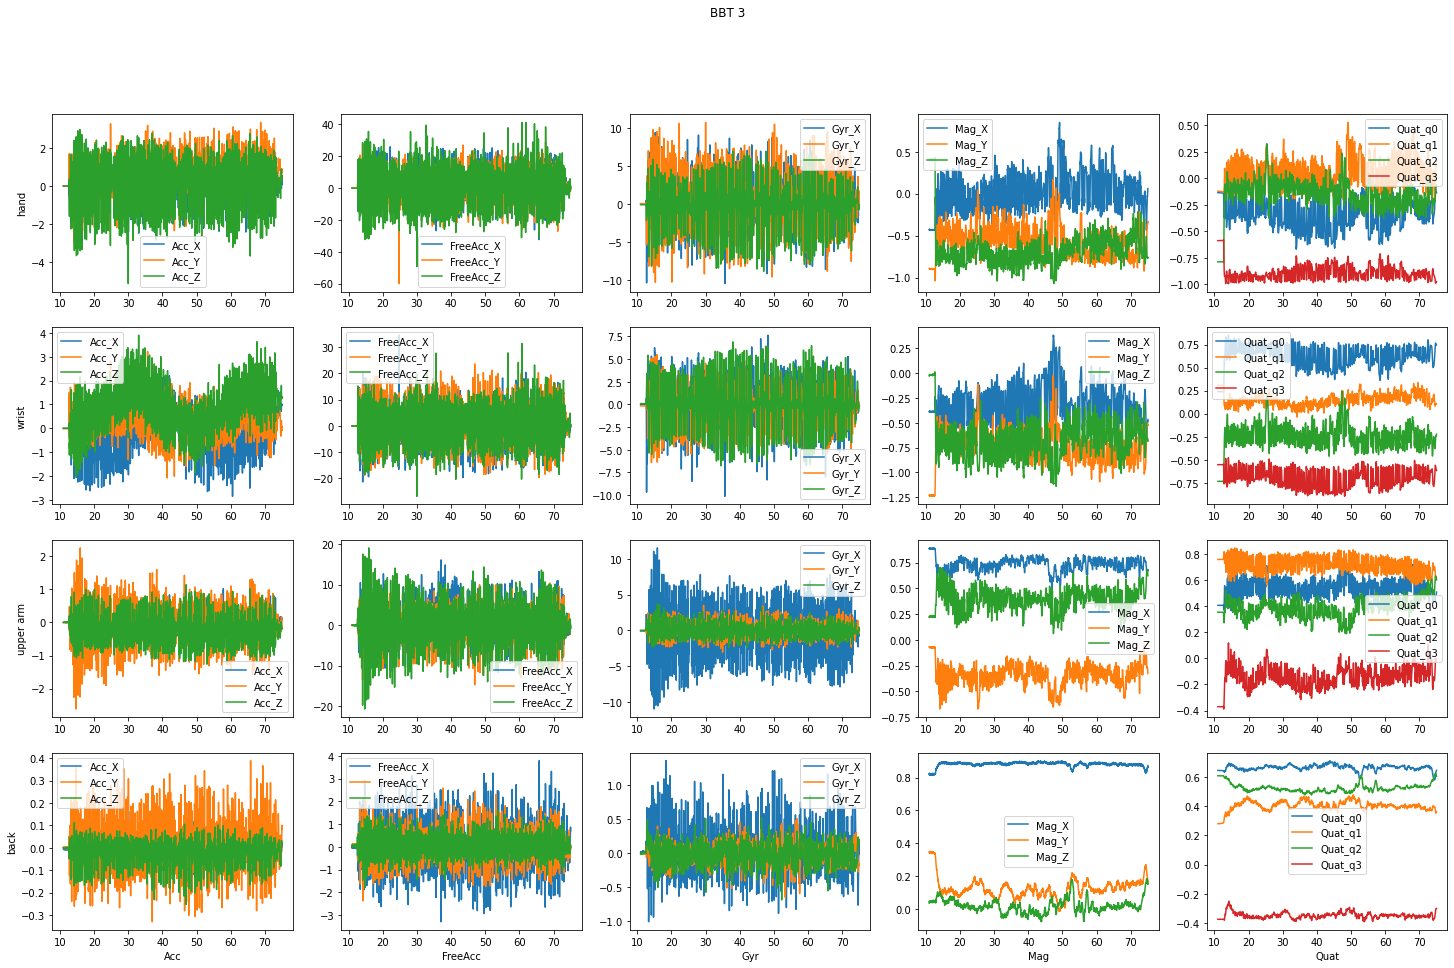

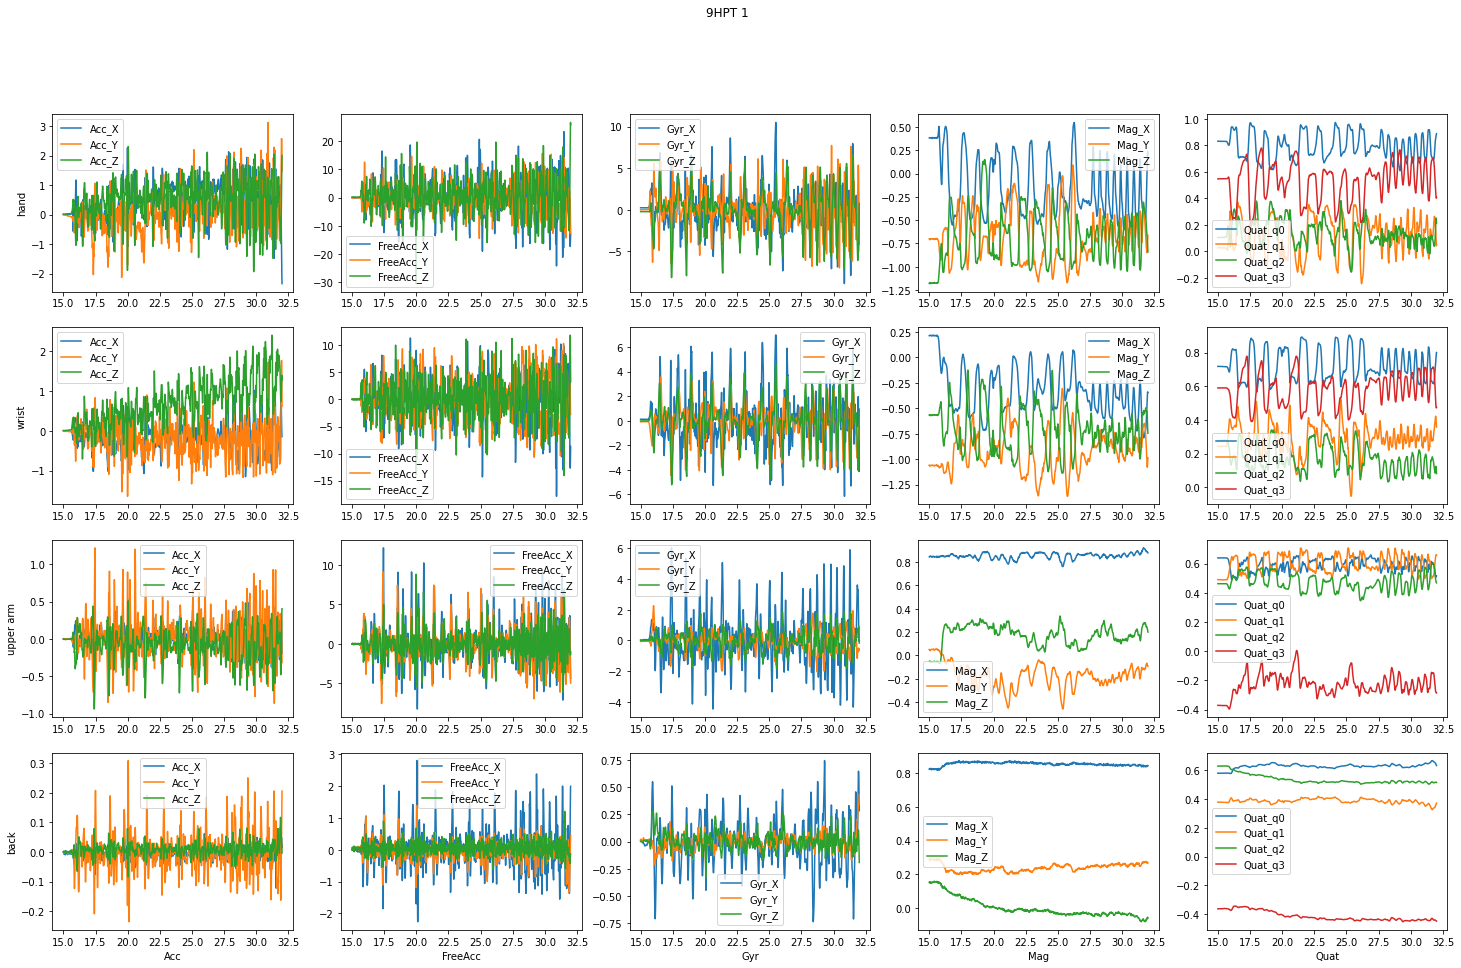

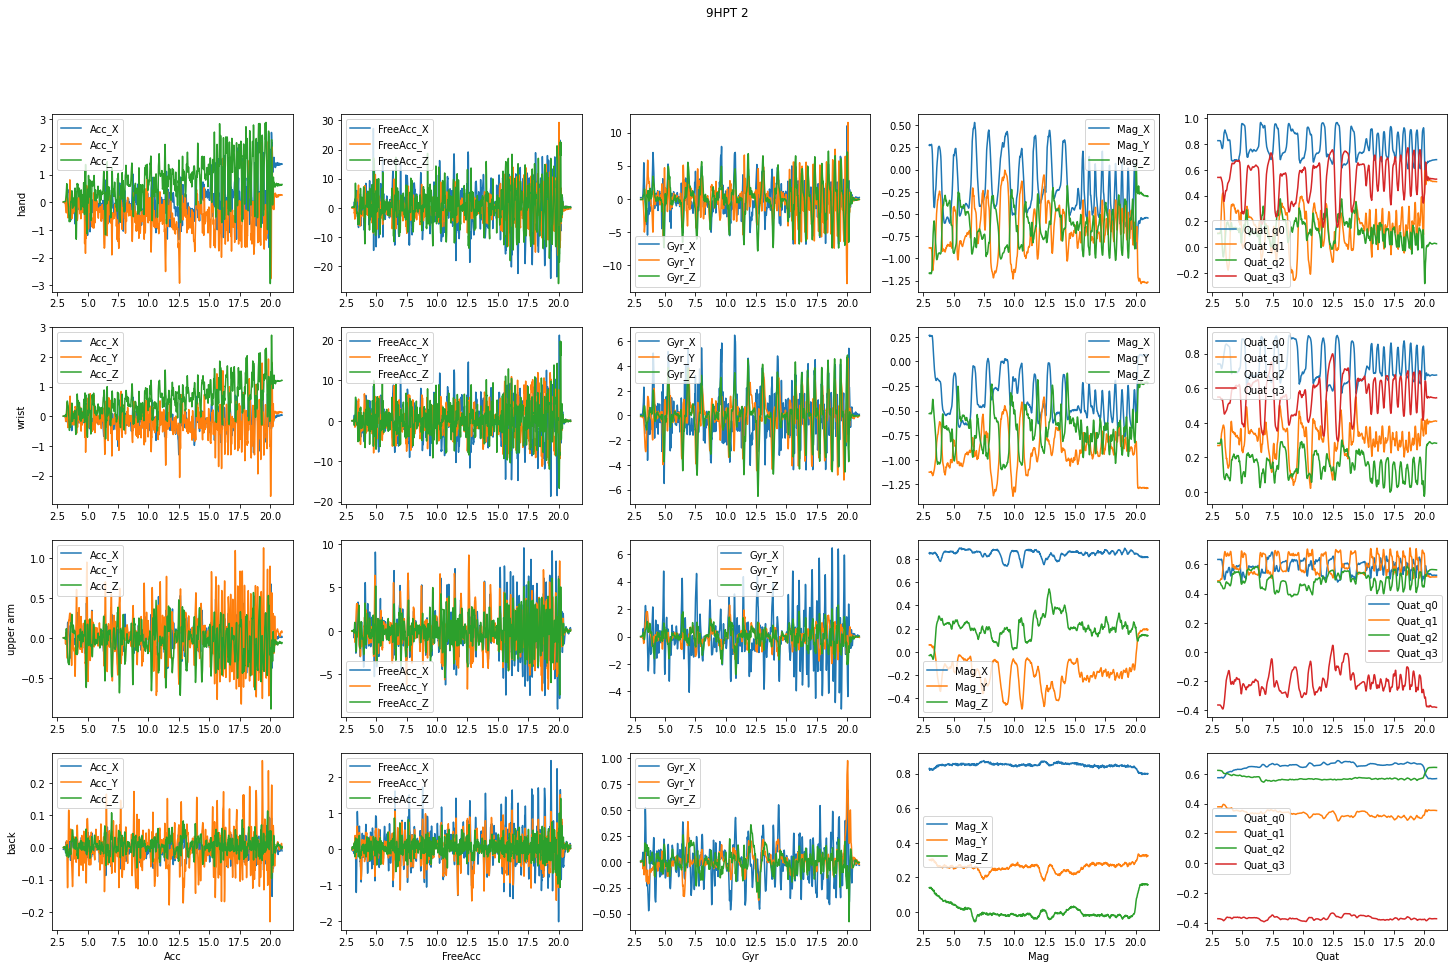

In [24]:
def plot(tasks, sensors, signal_types):
    
    for task_type in data_raw:
        if task_type in tasks:
            for task in data_raw[task_type]:
                num_rows = len(sensors)
                num_cols = len(signal_types)
                if num_rows != 1 and num_cols != 1:
                    fig, axs = plt.subplots(nrows=num_rows, ncols = num_cols, figsize = (25,15))
                elif num_rows != 1:
                    fig, axs = plt.subplots(ncols = num_cols, figsize = (20,15))
                elif num_cols != 1:
                    fig, axs = plt.subplots(nrows=num_rows, figsize = (20,15))
                i = 0
                for sensor in data_raw[task_type][task]:
                    if sensor in sensors:
                        j = 0
                        for signal_type in data_raw[task_type][task][sensor]:
                            if signal_type in signal_types:
                                axs[i,j].plot(data[task_type][task][sensor][signal_type], label = data[task_type][task][sensor][signal_type].columns)
                                if task_type in splitting_points:
                                    for curr_splitting_point in splitting_points[task_type][task]:
                                        axs[i,j].axvline(curr_splitting_point)
                                axs[i,j].legend()
                                if j == 0:
                                    axs[i,j].set_ylabel(get_sensor_position_by_id(sensor))
                                if i == len(sensors) - 1:
                                    axs[i,j].set_xlabel(signal_type)
                                j += 1
                        i += 1
                fig.suptitle(task)
                plt.show()
                plt.close('all')
                                
plot(['heading reset'], [id_hand_imu, id_wrist_imu, id_upper_arm_imu,id_back_imu], ['Acc', 'FreeAcc', 'Gyr', 'Mag', 'Quat'])                             
plot(['calibration'], [id_hand_imu, id_wrist_imu, id_upper_arm_imu,id_back_imu], ['Acc', 'FreeAcc', 'Gyr', 'Mag', 'Quat'])    
plot(['pointing'], [id_hand_imu, id_wrist_imu, id_upper_arm_imu,id_back_imu], ['Acc', 'FreeAcc', 'Gyr', 'Mag', 'Quat'])         
plot(['BBT'], [id_hand_imu, id_wrist_imu, id_upper_arm_imu,id_back_imu], ['Acc', 'FreeAcc', 'Gyr', 'Mag', 'Quat'])         
plot(['9HPT in'], [id_hand_imu, id_wrist_imu, id_upper_arm_imu,id_back_imu], ['Acc', 'FreeAcc', 'Gyr', 'Mag', 'Quat'])     
#plot(['9HPT out'], [id_hand_imu, id_wrist_imu, id_upper_arm_imu,id_back_imu], ['Acc', 'FreeAcc', 'Gyr', 'Mag', 'Quat'])         
#plot(['orientation'], [id_hand_imu, id_wrist_imu, id_upper_arm_imu,id_back_imu], ['Acc', 'FreeAcc', 'Gyr', 'Mag', 'Quat'])           